Three types of experiments were perfomed for each input set:

1) Reddit data

2) AMI followed by Reddit data

3) Average of AMI and Reddit

In [ ]:
# 1) Random Forest (RF), 
# 3) Support Vector Machines classifier (SVM), 
# 4) Logistic Regression,  

#check wrong preds
#multiclass
#late fusion blended model
#k fold cross validation
#In this blended model the probabilities of belonging to different classes from the simple models were summed and averaged. We marked as a final choice the class which had the highest average probability.

In [ ]:
!pip install transformers 

# Data Processing
import pandas as pd
import numpy as np
import pickle
import joblib

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

import torch
from transformers import AutoTokenizer, AutoModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.4 MB/s eta 0:00:00


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.9 MB/s eta 0:00:00


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_ami_train = pd.read_csv('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_train.csv')
df_ami_test = pd.read_csv('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_test.csv')

In [ ]:
df_reddit_train = pd.read_csv('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/train.csv')
df_reddit_test = pd.read_csv('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/test.csv')

In [ ]:
def bert_embeddings(df_train,df_test):
  tokenized_train = tokenizer(df_train["text"].values.tolist(), padding = True, truncation = True, return_tensors="pt")
  tokenized_val = tokenizer(df_test["text"].values.tolist() , padding = True, truncation = True,  return_tensors="pt")
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}
  with torch.no_grad():
    hidden_train = model(**tokenized_train) #dim : [batch_size(nr_sentences), tokens, emb_dim]
    hidden_val = model(**tokenized_val)
  #get only the [CLS] hidden states
  cls_train = hidden_train.last_hidden_state[:,0,:]
  cls_val = hidden_val.last_hidden_state[:,0,:]
  x_train = cls_train.to("cpu")
  y_train = df_ami_train["label"]

  x_val = cls_val.to("cpu")
  y_val = df_ami_test["label"]
  return x_train,y_train,x_val,y_val


### Generate Embeddings for AMI dataset

In [ ]:
x_train_ami,y_train_ami,x_val_ami,y_val_ami = bert_embeddings(df_ami_train,df_ami_test)

<ipython-input-5-762673f0a898>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
<ipython-input-5-762673f0a898>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


In [ ]:
with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_xtrain_embedding.pickle', 'wb') as pkl:
    pickle.dump(x_train_ami, pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_ytrain_embedding.pickle', 'wb') as pkl:
    pickle.dump(y_train_ami, pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_xval_embedding.pickle', 'wb') as pkl:
    pickle.dump(x_val_ami, pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_yval_embedding.pickle', 'wb') as pkl:
    pickle.dump(y_val_ami, pkl)   

### Generate Embeddings for Reddit dataset (added directly from another notebook)

In [ ]:
x_train_reddit,y_train_reddit,x_val_reddit,y_val_reddit = bert_embeddings(df_reddit_train,df_reddit_test)

<ipython-input-5-762673f0a898>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}
<ipython-input-5-762673f0a898>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}


OutOfMemoryError: ignored

In [ ]:
with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_xtrain_embedding.pickle', 'wb') as pkl:
    pickle.dump(x_train_reddit, pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_ytrain_embedding.pickle', 'wb') as pkl:
    pickle.dump(y_train_reddit, pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_xval_embedding.pickle', 'wb') as pkl:
    pickle.dump(x_val_reddit, pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_yval_embedding.pickle', 'wb') as pkl:
    pickle.dump(y_val_reddit, pkl)  

### Running ML pipeline on AMI dataset

In [ ]:
with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_xtrain_embedding.pickle', 'rb') as pkl:
    x_train_ami = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_ytrain_embedding.pickle', 'rb') as pkl:
    y_train_ami = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_xval_embedding.pickle', 'rb') as pkl:
    x_val_ami = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/ami_data/ami_yval_embedding.pickle', 'rb') as pkl:
    y_val_ami = pickle.load(pkl)  

In [ ]:
x_train_ami.shape

torch.Size([3986, 768])

In [ ]:
y_train_ami.shape

(3986,)

In [ ]:
x_val_reddit.shape

torch.Size([1301, 768])

In [ ]:
y_val_reddit.shape

(1301,)

In [ ]:
name='GaussianNB'
#estimator = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))
#print(estimator.best_estimator_)
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
#model.fit(x_train_reddit.cpu(),y_train_reddit)
model.fit(x_train_ami,y_train_ami)
preds = model.predict(x_val_reddit.cpu())

In [ ]:
y_train_reddit

0       0
1       0
2       1
3       0
4       0
       ..
5249    1
5250    1
5251    1
5252    1
5253    1
Name: label, Length: 5254, dtype: int64

In [ ]:
preds = model.predict(x_val_reddit.cpu().detach().numpy())
accuracy = accuracy_score(y_val_reddit, preds)
precision = precision_score(y_val_reddit, preds)
recall = recall_score(y_val_reddit, preds)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9008455034588778
Precision: 0.0
Recall: 0.0


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
processed_data = {}
def construct_model_ami(x_train,y_train):
    # the list of classifiers to use
    # use random_state for reproducibility
    classifiers = [
        LogisticRegression(random_state=0), 
        DecisionTreeClassifier(random_state=0),
        SVC(random_state=0), 
        
    ]
    
    logregress_parameters = { 
        'C'       : np.logspace(-1,1,3),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    }
    
    svc_parameters ={   
        'C': [0.1, 1, 10], 
        'gamma': [1, 0.1, 0.01],
        'kernel': ['linear']
    } 
    dt_parameters = {
        'criterion':['gini','entropy'],
        'max_depth':[4,6,10]
    }
    # stores all the paramete rs in a list 
    parameters = [
        logregress_parameters, 
        dt_parameters,
        svc_parameters, 
        
    ]
    # estimators is a list of tuple -> 
    #   [(name_of_classifier, tuned_estimator)]
    processed_data['estimators'] = []
    
    # iterate through each classifier and use GridSearchCV
    for i, classifier in enumerate(classifiers):
        clf = GridSearchCV(classifier,              # model
                  param_grid = parameters[i], # hyperparameters
                  scoring='accuracy',         # metric for scoring
                  cv=10,
                  n_jobs=-1, error_score='raise')
        #X_train, processed_data['X_test'], y_train, processed_data['y_test'], indices_train, processed_data['indices_test'] = train_test_split(features, labels, dataframe.index, test_size=0.33, random_state=0, shuffle=True)
        clf.fit(x_train,y_train)
        # add the clf to the estimators list
        processed_data['estimators'].append((classifier.__class__.__name__, clf))  

In [ ]:
construct_model_ami(x_train_ami,y_train_ami)

NameError: ignored

In [ ]:
import pickle
for name, clf in processed_data['estimators']:
    print(name)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    print("__________________________________________________________")
    with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name),'wb') as f:
      pickle.dump(clf.best_estimator_, f)
    #joblib.dump(clf, '/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))

LogisticRegression
Tuned Hyperparameters : {'C': 1.0, 'solver': 'liblinear'}
Accuracy : 0.7590729335902571
__________________________________________________________
GaussianNB
Tuned Hyperparameters : {'var_smoothing': 1e-09}
Accuracy : 0.7094205362652863
__________________________________________________________
SVC
Tuned Hyperparameters : {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Accuracy : 0.7565622599211597
__________________________________________________________


In [ ]:
GaussianNB()

SVC(C=0.1, gamma=1, kernel='linear')
Accuracy: 0.676402767102229
Precision: 0.18803418803418803
Recall: 0.6821705426356589
Classification Report:


              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1172
           1       0.19      0.68      0.29       129

    accuracy                           0.68      1301
   macro avg       0.57      0.68      0.54      1301
weighted avg       0.88      0.68      0.74      1301



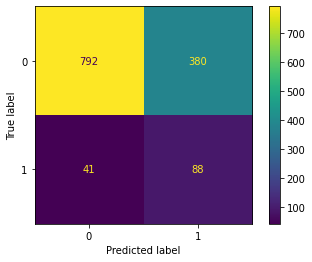

In [ ]:
best_model('SVC')

LogisticRegression(solver='liblinear')
Accuracy: 0.7471176018447349
Precision: 0.1875
Recall: 0.46511627906976744
Classification Report:


              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1172
           1       0.19      0.47      0.27       129

    accuracy                           0.75      1301
   macro avg       0.56      0.62      0.56      1301
weighted avg       0.86      0.75      0.79      1301



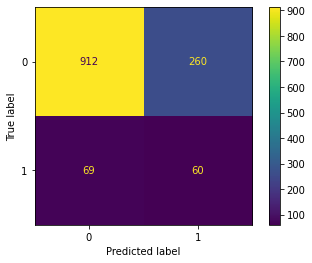

In [ ]:
best_model('LogisticRegression')

GaussianNB()
Accuracy: 0.9008455034588778
Precision: 0.0
Recall: 0.0
Classification Report:


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1172
           1       0.00      0.00      0.00       129

    accuracy                           0.90      1301
   macro avg       0.45      0.50      0.47      1301
weighted avg       0.81      0.90      0.85      1301



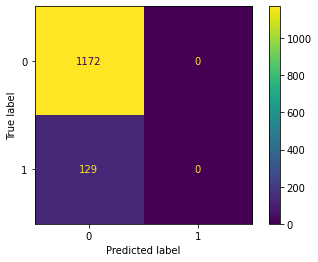

In [ ]:
best_model('GaussianNB')

In [ ]:
processed_data = {}
def construct_model(x_train,y_train):
    # the list of classifiers to use
    # use random_state for reproducibility
    classifiers = [
        LogisticRegression(random_state=0), 
        SVC(random_state=0), 
        RandomForestClassifier(random_state=0)
    ]
    
    logregress_parameters = { 
        'C'       : np.logspace(-1,1,3),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    }
    
    svc_parameters ={   
        'C': [0.1, 1, 10], 
        'gamma': [1, 0.1, 0.01],
        'kernel': ['linear']
    } 
    randomforest_parameters = {
        'n_estimators': [50, 100, 200]
    }
    # stores all the paramete rs in a list 
    parameters = [
        logregress_parameters, 
        svc_parameters, 
        randomforest_parameters
    ]
    # estimators is a list of tuple -> 
    #   [(name_of_classifier, tuned_estimator)]
    processed_data['estimators'] = []
    
    # iterate through each classifier and use GridSearchCV
    for i, classifier in enumerate(classifiers):
        clf = GridSearchCV(classifier,              # model
                  param_grid = parameters[i], # hyperparameters
                  scoring='accuracy',         # metric for scoring
                  cv=10,
                  n_jobs=-1, error_score='raise')
        #X_train, processed_data['X_test'], y_train, processed_data['y_test'], indices_train, processed_data['indices_test'] = train_test_split(features, labels, dataframe.index, test_size=0.33, random_state=0, shuffle=True)
        clf.fit(x_train,y_train)
        # add the clf to the estimators list
        processed_data['estimators'].append((classifier.__class__.__name__, clf))  

In [ ]:
construct_model(x_train_ami,y_train_ami)

In [ ]:
processed_data

{'estimators': [('LogisticRegression', GridSearchCV(cv=10, error_score='raise',
                estimator=LogisticRegression(random_state=0), n_jobs=-1,
                param_grid={'C': array([ 0.1,  1. , 10. ]),
                            'solver': ['newton-cg', 'lbfgs', 'liblinear']},
                scoring='accuracy')),
  ('SVC',
   GridSearchCV(cv=10, error_score='raise', estimator=SVC(random_state=0),
                n_jobs=-1,
                param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                            'kernel': ['linear']},
                scoring='accuracy')),
  ('RandomForestClassifier', GridSearchCV(cv=10, error_score='raise',
                estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
                param_grid={'n_estimators': [50, 100, 200]}, scoring='accuracy'))]}

In [ ]:
for name, clf in processed_data['estimators']:
    print(name)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    print("__________________________________________________________")
    joblib.dump(clf.best_estimator_, '/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))

LogisticRegression
Tuned Hyperparameters : {'C': 1.0, 'solver': 'liblinear'}
Accuracy : 0.7590729335902571
__________________________________________________________
SVC
Tuned Hyperparameters : {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Accuracy : 0.7565622599211597
__________________________________________________________
RandomForestClassifier
Tuned Hyperparameters : {'n_estimators': 200}
Accuracy : 0.7232333345927633
__________________________________________________________


### Retraining on the best model parameters from GridSearch for AMI dataset

In [ ]:
def best_model(name):
  estimator = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))
  print(estimator)
  estimator.fit(x_train_ami,y_train_ami)
  preds = estimator.predict(x_val_reddit.cpu().detach().numpy())
  accuracy = accuracy_score(y_val_reddit, preds)
  precision = precision_score(y_val_reddit, preds)
  recall = recall_score(y_val_reddit, preds)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  # Create the confusion matrix
  cm = confusion_matrix(y_val_reddit, preds)
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  print('Classification Report:')
  print('\n')
  print(classification_report(y_val_reddit, preds))

In [ ]:
with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_xtrain_embedding.pickle', 'rb') as pkl:
    x_train_reddit = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_ytrain_embedding.pickle', 'rb') as pkl:
    y_train_reddit = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_xval_embedding.pickle', 'rb') as pkl:
    x_val_reddit = pickle.load(pkl)

with open('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/data/reddit_data/reddit_yval_embedding.pickle', 'rb') as pkl: 
    y_val_reddit = pickle.load(pkl)

In [ ]:
#testing on Reddit
x_train_reddit = x_train_reddit.reshape(-1,x_train_reddit.shape[-1])
x_val_reddit = x_val_reddit.reshape(-1,x_val_reddit.shape[-1])

SVC(C=0.1, gamma=1, kernel='linear', random_state=0)
Accuracy: 0.676402767102229
Precision: 0.18803418803418803
Recall: 0.6821705426356589
Classification Report:


              precision    recall  f1-score   support

           0       0.95      0.68      0.79      1172
           1       0.19      0.68      0.29       129

    accuracy                           0.68      1301
   macro avg       0.57      0.68      0.54      1301
weighted avg       0.88      0.68      0.74      1301



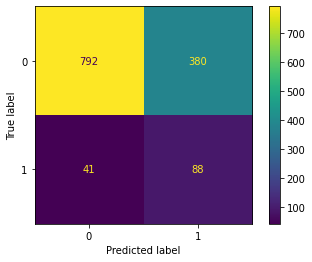

In [ ]:
best_model('SVC')

LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.7471176018447349
Precision: 0.1875
Recall: 0.46511627906976744
Classification Report:


              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1172
           1       0.19      0.47      0.27       129

    accuracy                           0.75      1301
   macro avg       0.56      0.62      0.56      1301
weighted avg       0.86      0.75      0.79      1301



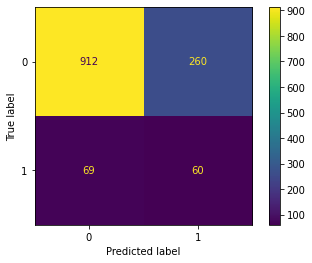

In [ ]:
best_model('LogisticRegression')

RandomForestClassifier(n_estimators=200, random_state=0)
Accuracy: 0.7348193697156034
Precision: 0.16037735849056603
Recall: 0.3953488372093023
Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1172
           1       0.16      0.40      0.23       129

    accuracy                           0.73      1301
   macro avg       0.54      0.58      0.53      1301
weighted avg       0.85      0.73      0.78      1301



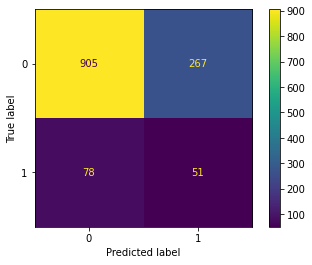

In [ ]:
best_model('RandomForestClassifier')

### Running ML pipeline on Reddit dataset

In [ ]:
processed_data = {}
def construct_model_reddit(x_train,y_train):
    # the list of classifiers to use
    # use random_state for reproducibility
    classifiers = [
        LogisticRegression(random_state=0), 
        SVC(random_state=0), 
        RandomForestClassifier(random_state=0)
    ]
    
    logregress_parameters = { 
        'C'       : np.logspace(-1,1,3),
        'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    }
    
    svc_parameters ={   
        'C': [0.1, 1, 10], 
        'gamma': [1, 0.1, 0.01],
        'kernel': ['linear']
    } 
    randomforest_parameters = {
        'n_estimators': [50, 100, 200]
    }
    # stores all the paramete rs in a list 
    parameters = [
        logregress_parameters, 
        svc_parameters, 
        randomforest_parameters
    ]
    # estimators is a list of tuple -> 
    #   [(name_of_classifier, tuned_estimator)]
    processed_data['estimators'] = []
    
    # iterate through each classifier and use GridSearchCV
    for i, classifier in enumerate(classifiers):
        clf = GridSearchCV(classifier,              # model
                  param_grid = parameters[i], # hyperparameters
                  scoring='roc_auc',         # metric for scoring
                  cv=10,
                  n_jobs=-1, error_score='raise')
        #X_train, processed_data['X_test'], y_train, processed_data['y_test'], indices_train, processed_data['indices_test'] = train_test_split(features, labels, dataframe.index, test_size=0.33, random_state=0, shuffle=True)
        clf.fit(x_train,y_train)
        # add the clf to the estimators list
        processed_data['estimators'].append((classifier.__class__.__name__, clf))  

In [ ]:
construct_model_reddit(x_train_reddit.cpu(),y_train_reddit)

In [ ]:
for name, clf in processed_data['estimators']:
    print(name)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    print("__________________________________________________________")
    joblib.dump(clf.best_estimator_, '/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/reddit_{0}_best_model.pkl'.format(name))

LogisticRegression
Tuned Hyperparameters : {'C': 0.1, 'solver': 'lbfgs'}
Accuracy : 0.8673558817313726
__________________________________________________________
SVC
Tuned Hyperparameters : {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Accuracy : 0.8340732555972148
__________________________________________________________
RandomForestClassifier
Tuned Hyperparameters : {'n_estimators': 200}
Accuracy : 0.7818927621068232
__________________________________________________________


### Retraining on the best model parameters from GridSearch for Reddit dataset

In [ ]:
def best_model_reddit(name):
  estimator = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/reddit_{0}_best_model.pkl'.format(name))
  print(estimator)
  estimator.fit(x_train_reddit.cpu(),y_train_reddit)
  preds = estimator.predict(x_val_reddit.cpu().detach().numpy())
  accuracy = accuracy_score(y_val_reddit, preds)
  precision = precision_score(y_val_reddit, preds)
  recall = recall_score(y_val_reddit, preds)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  # Create the confusion matrix
  cm = confusion_matrix(y_val_reddit, preds)
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  print('Classification Report:')
  print('\n')
  print(classification_report(y_val_reddit, preds))

SVC(C=0.1, gamma=1, kernel='linear', random_state=0)
Accuracy: 0.9116064565718678
Precision: 0.6521739130434783
Recall: 0.23255813953488372
Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1172
           1       0.65      0.23      0.34       129

    accuracy                           0.91      1301
   macro avg       0.79      0.61      0.65      1301
weighted avg       0.89      0.91      0.89      1301



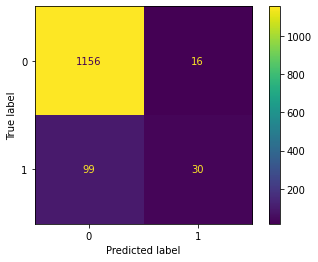

In [ ]:
best_model_reddit('SVC')

LogisticRegression(C=0.1, random_state=0)
Accuracy: 0.9093005380476556
Precision: 0.6078431372549019
Recall: 0.24031007751937986
Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1172
           1       0.61      0.24      0.34       129

    accuracy                           0.91      1301
   macro avg       0.76      0.61      0.65      1301
weighted avg       0.89      0.91      0.89      1301



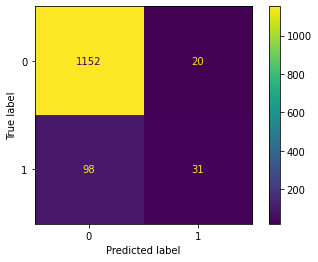

In [ ]:
best_model_reddit('LogisticRegression')

RandomForestClassifier(n_estimators=200, random_state=0)
Accuracy: 0.9023827824750192
Precision: 1.0
Recall: 0.015503875968992248
Classification Report:


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1172
           1       1.00      0.02      0.03       129

    accuracy                           0.90      1301
   macro avg       0.95      0.51      0.49      1301
weighted avg       0.91      0.90      0.86      1301



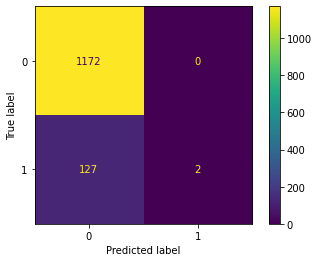

In [ ]:
best_model_reddit('RandomForestClassifier')

In [ ]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 300],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5],
    #'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring='f1')
CV_rfc.fit(x_train_reddit.cpu(),y_train_reddit)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [4, 5], 'n_estimators': [200, 300]},
             scoring='f1')

In [ ]:
x_train_reddit.cpu().shape

torch.Size([5254, 768])

In [ ]:
y_train_reddit.shape

(5254,)

In [ ]:
#estimator = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/reddit_RandomForestClassifier_best_model.pkl')
clf = RandomForestClassifier()
clf.fit(x_train_reddit.cpu(),y_train_reddit)

RandomForestClassifier()

In [ ]:
preds = CV_rfc.predict(x_val_reddit.cpu().detach().numpy())
accuracy = accuracy_score(y_val_reddit, preds)
precision = precision_score(y_val_reddit, preds)
recall = recall_score(y_val_reddit, preds)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9008455034588778
Precision: 0.0
Recall: 0.0


Classification Report:


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1172
           1       0.00      0.00      0.00       129

    accuracy                           0.90      1301
   macro avg       0.45      0.50      0.47      1301
weighted avg       0.81      0.90      0.85      1301



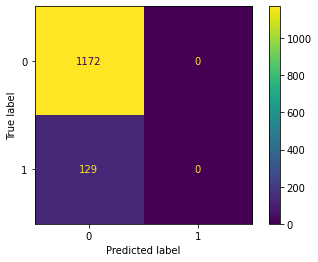

In [ ]:
cm = confusion_matrix(y_val_reddit, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();
print('Classification Report:')
print('\n')
print(classification_report(y_val_reddit, preds))

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train_reddit.cpu(),y_train_reddit)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
preds = xgb_cl.predict(x_val_reddit.cpu().detach().numpy())
accuracy = accuracy_score(y_val_reddit, preds)
precision = precision_score(y_val_reddit, preds)
recall = recall_score(y_val_reddit, preds)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9069946195234435
Precision: 0.75
Recall: 0.09302325581395349


Classification Report:


              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1172
           1       0.75      0.09      0.17       129

    accuracy                           0.91      1301
   macro avg       0.83      0.54      0.56      1301
weighted avg       0.89      0.91      0.87      1301



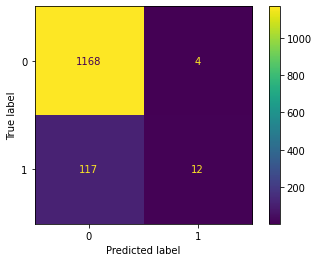

In [ ]:
cm = confusion_matrix(y_val_reddit, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();
print('Classification Report:')
print('\n')
print(classification_report(y_val_reddit, preds))

In [ ]:
import xgboost as xgb
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': [2,5],
    #'n_estimators': [100,300],
    #'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    #n_jobs = 10,
    cv = 5,
    verbose=True
)
grid_search.fit(x_train_reddit.cpu(),y_train_reddit)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


KeyboardInterrupt: ignored

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(x_train_reddit.cpu(),y_train_reddit)

GaussianNB()

In [ ]:
preds = model.predict(x_val_ami)
accuracy = accuracy_score(y_val_ami, preds)
precision = precision_score(y_val_ami, preds)
recall = recall_score(y_val_ami, preds)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5370741482965932
Precision: 0.0
Recall: 0.0


In [ ]:
preds = model.predict(x_val_reddit.cpu().detach().numpy())
accuracy = accuracy_score(y_val_reddit, preds)
precision = precision_score(y_val_reddit, preds)
recall = recall_score(y_val_reddit, preds)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7417371252882398
Precision: 0.23393316195372751
Recall: 0.7054263565891473


Classification Report:


              precision    recall  f1-score   support

           0       0.96      0.75      0.84      1172
           1       0.23      0.71      0.35       129

    accuracy                           0.74      1301
   macro avg       0.60      0.73      0.60      1301
weighted avg       0.89      0.74      0.79      1301



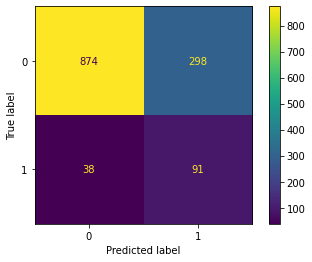

In [ ]:
cm = confusion_matrix(y_val_reddit, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();
print('Classification Report:')
print('\n')
print(classification_report(y_val_reddit, preds))

Classification Report:


              precision    recall  f1-score   support

           0       0.64      0.75      0.69       538
           1       0.63      0.51      0.56       460

    accuracy                           0.64       998
   macro avg       0.64      0.63      0.63       998
weighted avg       0.64      0.64      0.63       998



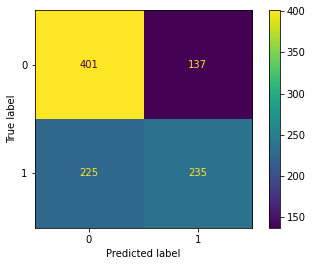

In [ ]:
cm = confusion_matrix(y_val_ami, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();
print('Classification Report:')
print('\n')
print(classification_report(y_val_ami, preds))

In [ ]:
from statistics import mean
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('f1', 'recall', 'precision')
#Evaluate SRF model
scores = cross_validate(xgb_cl, x_train_reddit.cpu(),y_train_reddit, scoring=scoring, cv=cv)
#Get average evaluation metrics
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

KeyboardInterrupt: ignored

In [ ]:
y_val_reddit

0       0
1       0
2       0
3       0
4       0
       ..
1296    0
1297    1
1298    1
1299    1
1300    1
Name: label, Length: 1301, dtype: int64

### Fine tuning best models trained on AMI by retraining with Reddit

In [ ]:
def best_model_ami_reddit(name):
  estimator = joblib.load('/content/drive/MyDrive/CSCI 535 Project/Implementation/training_models/models/ami_{0}_best_model.pkl'.format(name))
  print(estimator)
  estimator.fit(x_train_reddit.cpu(),y_train_reddit)
  preds = estimator.predict(x_val_reddit.cpu().detach().numpy())
  accuracy = accuracy_score(y_val_reddit, preds)
  precision = precision_score(y_val_reddit, preds)
  recall = recall_score(y_val_reddit, preds)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  # Create the confusion matrix
  cm = confusion_matrix(y_val_reddit, preds)
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();
  print('Classification Report:')
  print('\n')
  print(classification_report(y_val_reddit, preds))

SVC(C=0.1, gamma=1, kernel='linear', random_state=0)
Accuracy: 0.9116064565718678
Precision: 0.6521739130434783
Recall: 0.23255813953488372
Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1172
           1       0.65      0.23      0.34       129

    accuracy                           0.91      1301
   macro avg       0.79      0.61      0.65      1301
weighted avg       0.89      0.91      0.89      1301



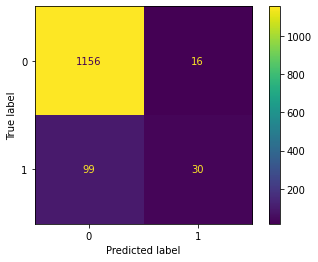

In [ ]:
best_model_ami_reddit('SVC')

LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.8954650269023828
Precision: 0.4520547945205479
Recall: 0.2558139534883721
Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1172
           1       0.45      0.26      0.33       129

    accuracy                           0.90      1301
   macro avg       0.69      0.61      0.64      1301
weighted avg       0.88      0.90      0.88      1301



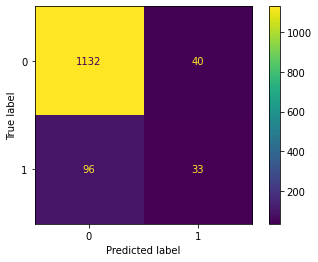

In [ ]:
best_model_ami_reddit('LogisticRegression')

RandomForestClassifier(n_estimators=200, random_state=0)
Accuracy: 0.9023827824750192
Precision: 1.0
Recall: 0.015503875968992248
Classification Report:


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1172
           1       1.00      0.02      0.03       129

    accuracy                           0.90      1301
   macro avg       0.95      0.51      0.49      1301
weighted avg       0.91      0.90      0.86      1301



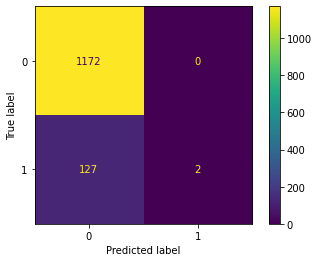

In [ ]:
best_model_ami_reddit('RandomForestClassifier')

In [ ]:
#class imbalance handle?

### Combining 6 models 

In [ ]:
aw